Online-Kurs zu Modellierung und Simulation, Goethe-Universität-Frankfurt | [Startseite](../index.ipynb)

---

# Beispiel: Reduziertes Modellproblem

Betrachten das I_K+I_NA Modell aus *Izhikevich, Dynamical Systems in Neuroscience, MIT press, 2010, Kapitel 4*. 


Hierfür lautet die gewöhnliche DGL :
\begin{align*}
C \dot V &= \color{blue}{I(t)} - g_{Na} \cdot m_\infty(V) \cdot  (V-E_{Na}) - g_K \cdot n \cdot (V-E_K) - \overline g_L(V-\color{red}{E_L})\\
\tau_n(V) \dot n &= \color{red}{n_\infty(V)} - n 
\end{align*}
Dabei ist $V$ das Membranpotential und $0 \le n \le 1$ die Wahrscheinlichkeit, dass Kanäle offen sind. 

## Definitionen
### Globale Parameter

In [1]:
tau=1.0
global E_Na = +60.0    # mV
global E_K  = -90.0    # mV

global g_L= 8.0
global g_Na = 20.0
global g_K  = 10.0

global t0 = 0.0                       # Startzeitpunkt
global tend = 20.0                    # Endzeitpunkt

tau =  1


Die beiden $\color{red}{\text {hervorgehobenen}}$ Größen führen zu unterschiedlichem Verhalten. 

Fall a) Sattelpunkt:

In [2]:
#Sattelpunkt
global Vhalf_n = -25.0 # SADDLE aka HIGH: Bifurkation: I \approx 4.513/4
global E_L  = -80.0    # Sattelpunktsbifurkation/1-3 Schnittpunkte/Integrator
    
# SADDLE: I=0-4-5-10 
global ISrc0 = 0.0 # 14.4   -- 4.0
global ISrc1 = 40.0 # 40   -- 10.0


Fall b) Hopf:

In [3]:
# Hopf
# HOPF: 0-14.5-40.0 

 #   global Vhalf_n = -45  # HOPF aka LOW:   Bifurkation: I\approx 14
 #   global E_L  = -78.0   # Hopfbifurkation/1 Schnittpunkt/Resonator 
    
 #   global ISrc0 = 14.4 # 14.4   -- 4.0
 #   global ISrc1 = 40.0 # 40   -- 10.0

Für Plots

In [4]:
global V_min = -80.0
global V_max = +20.0

global n_min = 0.0
global n_max = 1.0

### Funktionen
\begin{align*}
m_{\infty}(V) &:=\frac{1}{1+\exp(\frac{-20.0-V}{15.0})}\\
n_{\infty}(V) &:=\frac{1}{1+\exp(\frac{-V_{n,1/2}-V}{5.0})}
\end{align*}

In [5]:
# Hilfgroesse m_{\infty}
function value=m_infty(V)
	 value = 1.0/(1.0+exp((-20.0-V)/15.0));
endfunction

# Hilfgroesse n_{\infty}
function value=n_infty(V)
	 global Vhalf_n 
 	 value = 1.0/(1.0+exp((Vhalf_n-V)/5.0));
endfunction

# Hilfgroesse \tau_n
function value=tau_n(V)
  value = 1.0; # 0.152; #1.0;  # 0.152 for Saddle (fast)
endfunction

Verschiedene $\color{blue}{\textrm{Ströme}}$ 

In [6]:
# Konstanter Strom
function value=IConst(t)
	 global ISrc0
	 value = ISrc0;
endfunction

#Stromrampe
function value=IRamp(t)
	 global ISrc0
	 global ISrc1
	 global tend
	 value = ISrc0+t/tend*(ISrc1-ISrc0);
endfunction

# Oszillation
function value=IPulse(t)
	 global ISrc0
	 global ISrc1
	 value = ISrc0+(2e-1)*(ISrc1-ISrc0)*sin(4/50*pi*t); #Sattelpunkt 
	 #value = ISrc0+1e-1*(ISrc1-ISrc0)*sin(7*t); # Hopf 2.11
endfunction

# Umschalter
function value=ISrcTime(t)
	 value = IConst(t); 
	 #value = IRamp(t); 
	 #value = IPulse(t); 
endfunction


In [7]:
# Hilfgroesse fuer Ionenstrom
function value=IIon(V,n)
	 global E_L
	 global E_Na
	 global E_K
	 global g_L
	 global g_Na
	 global g_K
	 value = g_L*(V-E_L) + g_Na* m_infty(V)*(V-E_Na) + g_K*n*(V-E_K);
endfunction

# Hilfgroesse fuer Ionenstrom
function value=I_infty(V)
	 global E_L
	 global E_Na
	 global E_K

	 global g_L
	 global g_Na
	 global g_K

	 global ISrc0
	 value = (g_L*(V-E_L) + g_Na* m_infty(V)*(V-E_Na) + g_K*n_infty(V)*(V-E_K));
endfunction

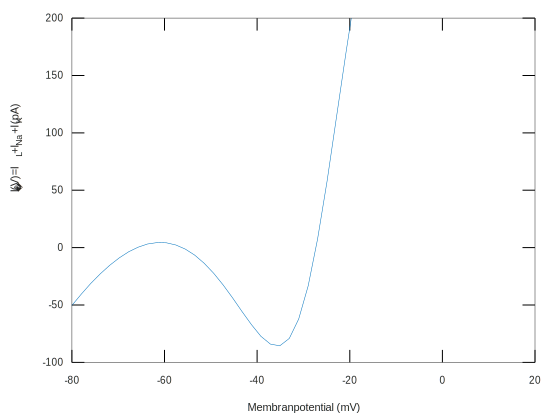

In [8]:
%plot -f svg
fig4=figure(4);
Vdisc = linspace(-80, 20, 50);
for i=1:50
Idisc(i) = I_infty(Vdisc(i));
end

plot(Vdisc, Idisc);
xlabel('Membranpotential (mV)')
ylabel('I_{\infty}(V)=I_L+I_{Na}+I_K (pA)')
ylim([-100, 200])

### Rechte Seite

In [9]:
# Definition des Feldes (rechte Seite der DGL)
function value=rhs(x, t)
	 global ISrc0;
	 V = x(1);
	 n = x(2);
	 
	 value(1) = ISrcTime(t) - IIon(V,n);
	 value(2) = (n_infty(V)-n) / tau_n(V);
endfunction

In [10]:
# Nachfolgende Gleichung beschreibt dV/dt=0
function value=dtV_zero(V)
	 global E_L
	 global E_Na
	 global E_K

	 global g_L
	 global g_Na
	 global g_K
	 global ISrc0
	
	value = (ISrc0-g_L*(V-E_L) - g_Na*m_infty(V)*(V-E_Na))/(g_K*(V-E_K));
endfunction


# Funktion zur Ausgabe des Vektorfelds
function plot_field(name)
	 V=linspace(-80,20,20);
	 n=linspace(0,1.0,20);
	 for j=1:length(n)
    	     for i=1:length(V)
    	     	 vec = rhs([V(i),n(j)], 0.0);
        	 dV(j,i) = vec(1);
        	 dn(j,i) = vec(2); 
    	     end
	end

	alpha = range(V)/range(n)
	axis ([-80 20 0 100]);
	quiver(V,n*alpha,dV,dn*alpha);	
endfunction



## Numerische Lösung

In [11]:
# Parametersatz "SADDLE"
x0=[-20; 0.25]             # Anfangswert (Grenzzyklus, tau=0.15)

I0=0.0
#x0=[-50; 0.1]             # Anfangswert (einfacher Spike, tau=1.0)

#x0=[-55, 0.1]             # Anfangswert (einfacher Spike, tau=0.15)
#x0=[-40, 0.1]             # Anfangswert (Oszillation, tau=0.15)

x0 =

  -20.00000
    0.25000

I0 = 0


In [12]:
# Parametersatz "HOPF"
#x0=[-40; 0.05]             # Anfangswert (Spiking, high)
#x0=[-58; 0.15]             # Anfangswert (Schwellwert, high)


## Diagramm 1: Darstellung im Richtungsfeld

alpha =  100
Paused, enter any value to continue


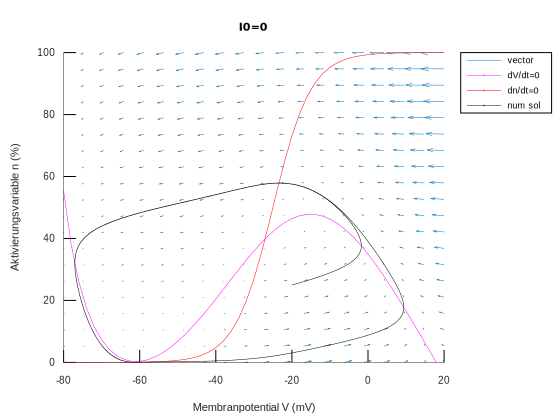

In [13]:
hold on

fig1=figure (1);
xlabel('Membranpotential V (mV)')
ylabel('Aktivierungsvariable n (%)')
label = sprintf("I0=%i",I0); 
title(label)

# a) Plotte Vektorfeld
plot_field('test')

# b) Plotte V-nullcline
x=-80:2:20;
for i=1:length(x) 
  dtV_zero(x(i));
  y(i)=dtV_zero(x(i))*100.0;
endfor
plot(x, y, 'color', 'm')

# c) Plotte n-nullcline
for i=1:length(x) y(i)=n_infty(x(i))*100.0; endfor
plot(x, y, 'color', 'r')

drawnow()
pause;

# Loese das AWP numerisch
time = linspace(t0, tend, 4000);
[sol, istate, msg]= lsode("rhs", x0, time);
plot (sol(:,1), sol(:,2)*100, 'color', 'black');
#print('-dpdf','-r300', filename1);


# Legende fuer Diagramm 1 
h = legend ('vector', 'dV/dt=0', 'dn/dt=0', 'num sol');
legend location northeastoutside
hold off



## Darstellung des Membranpotentials

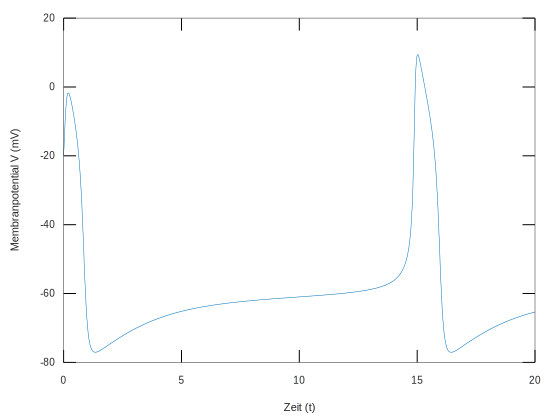

In [14]:
fig2=figure(2);
plot(time, sol(:,1));
axis([0 tend -80 20])
xlabel('Zeit (t)')
ylabel('Membranpotential V (mV)')


## Optional: Stabilitätsanalyse über Linearisierung

In [15]:
# Analysiere Linearisierung (Eigenwerte)
# (z.B. im Startwert/Gleichgewicht)
function check_linearization(xinf)
  deltaV= [1e-10; 0];
  deltan= [0; 1e-10];

  J(:,1)=(rhs(xinf+deltaV, 0) - rhs(xinf, 0))' / 1e-10;
  J(:,2)=(rhs(xinf+deltan, 0) - rhs(xinf, 0))' / 1e-10
  [V, lambda]=eigs(J);
  lambda
endfunction

In [16]:
# Startwert
check_linearization(x0)

# Berechne Linearisierung und Eigenwerte
# im Gleichgewicht
Vinf=sol(3950,1); 
ninf=sol(3950,2);
xinf=[Vinf; ninf]
check_linearization(xinf)


J =

     6.166374  -699.999987
     0.039322    -1.000000

lambda =

Diagonal Matrix

   2.5832 + 3.8322i                  0
                  0   2.5832 - 3.8322i

xinf =

  -65.825677
    0.011881

J =

    -1.809188355  -241.743220997
     0.000056847    -0.999999996

lambda =

Diagonal Matrix

  -1.7918        0
        0  -1.0174



In [17]:
# Konfiguriere Diagramm 3
#pause;
#fig3=figure(3);
#plot(time, sol(:,2));
#xlabel('Zeit (t)')
#ylabel('Gatingvariable n')


